# Sommaire

* [Introduction](#introduction)
* [I) Rapprochement des deux exports](#i)
    * [1) Importation des données](#i1)
    * [2) Nettoyage du jeu de données](#i2)
    * [3) Jointure des tables](#i3)
* [II) Requêtes](#ii)
    * [1) Chiffre d'affaire par produit](#ii1)
    * [2) Chiffre d'affaire total](#ii2)
* [III) Recherche d'outliers](#iii)
* [Conclusion](#conclusion)
    

# Introduction <a class="anchor" id="introduction"></a>

Pour faciliter la gestion des ressources de BottleNeck, nous rapprocherons un export ERP d'un export issu du site web. Cela nécessitera de nettoyer les données.

Ensuite nous exécuterons deux requêtes pour déterminer la chiffre d'affaire par produit, ainsi que le chiffre d'affaire total.

Enfin, nous identifierons les éventuels outliers et chercherons à déterminer si les valeurs sont aberrantes ou non.

# I) Rapprochement des deux exports <a class="anchor" id="i"></a>
## 1) Importation des données <a class="anchor" id="i1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

In [2]:
erp = pd.read_csv('erp.csv')
erp

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


In [3]:
liaison = pd.read_csv('liaison.csv')
liaison

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [4]:
web = pd.read_csv('web.csv')
web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


## 2) Nettoyage du jeu de données <a class="anchor" id="i2"></a>

In [5]:
#On renomme la colonne de la table liaison suite au mail de Sylvie
liaison.rename(columns={'id_web':'sku'}, inplace=True)
liaison

,product_id,sku
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [6]:
#Recherche des erreurs de type
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [7]:
web.dtypes
#Trop de colonnes, pas toutes utiles, on y reviendra plus tard finalement

sku                       object
virtual                    int64
downloadable               int64
rating_count               int64
average_rating           float64
total_sales              float64
tax_status                object
tax_class                float64
post_author              float64
post_date                 object
post_date_gmt             object
post_content             float64
post_title                object
post_excerpt              object
post_status               object
comment_status            object
ping_status               object
post_password            float64
post_name                 object
post_modified             object
post_modified_gmt         object
post_content_filtered    float64
post_parent              float64
guid                      object
menu_order               float64
post_type                 object
post_mime_type            object
comment_count            float64
dtype: object

In [8]:
liaison.dtypes

product_id     int64
sku           object
dtype: object

In [9]:
#Recherche de valeurs manquantes
erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [10]:
liaison.isnull().sum()

product_id     0
sku           91
dtype: int64

In [11]:
liaison.loc[liaison['sku'].isnull(),:]

,product_id,sku
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
817,7196,NaN
818,7200,NaN
819,7201,NaN
820,7203,NaN


In [12]:
web.isnull().sum()

sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              865
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

In [13]:
#85 SKU manquants, 83 valeurs manquantes dans beaucoup d'autres colonnes, voyons s'il y a un lien
web_mv = web.loc[web['sku'].isnull(),:]
web_mv.tail(50)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
738,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
web_mv.head(35)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#On efface ces données manquantes
web_altered = web.dropna(subset='sku')
web_altered

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [16]:
#Recherche de doublons
erp.loc[erp.duplicated(subset='product_id', keep=False)]

,product_id,onsale_web,price,stock_quantity,stock_status


In [17]:
liaison.loc[liaison.duplicated(subset='product_id', keep=False)]

,product_id,sku


In [18]:
liaison.loc[liaison.duplicated(subset='sku', keep=False)]
#Même nombre de lignes que de valeurs manquantes, en dehors de ces valeurs il n'y a donc pas de doublons

,product_id,sku
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
817,7196,NaN
818,7200,NaN
819,7201,NaN
820,7203,NaN


In [19]:
web_altered.loc[web_altered.duplicated(subset=['sku'], keep=False)]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [20]:
web_altered.loc[web_altered.duplicated(subset=['sku', 'total_sales', 'post_date'], keep=False)]
#Même résultat quand on sélectionne le nombre de vente et la date du post en plus du SKU

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [21]:
#On supprime les doublons
web_dd = web_altered.drop_duplicates(subset=['sku', 'total_sales', 'post_date'], keep='first', inplace=False, ignore_index=True).copy()
web_dd

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,16135,0,0,0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
710,15891,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
711,15887,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
712,13127-1,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [22]:
web_dd.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,714.0,714.0,714.0,714.0,714.000000,0.0,714.000000,0.0,0.0,0.0,714.0,714.0,714.0
mean,0.0,0.0,0.0,0.0,4.012605,NaN,1.998599,NaN,NaN,NaN,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.518183,NaN,0.037424,NaN,NaN,NaN,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


In [23]:
#On s'y perd avec toutes ces colonnes, on retire celles qui sont vides ou nulles
web_drop = web_dd.drop(columns=['virtual', 'downloadable', 'rating_count', 'average_rating', 'tax_class', 'post_content', 'post_password', 'post_content_filtered', 'post_parent', 'menu_order', 'comment_count'])
web_drop

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,16135,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,Belle robe jeune à dominante rubis soutenue. N...,publish,closed,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
710,15891,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,L'exotisme du nez est complété par d'élégantes...,publish,closed,closed,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
711,15887,0.0,taxable,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,"Pour cette cuvée, Jean-Paul Jamet recherche un...",publish,closed,closed,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
712,13127-1,0.0,taxable,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",publish,closed,closed,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.bottle-neck.fr/?post_type=product&...,product,NaN


In [24]:
#Il y en a toujours trop, on retire celles qui apportent des informations non pertinentes pour l'analyse
web_drop2 = web_drop.drop(columns=['tax_status', 'post_date_gmt', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_name', 'post_modified', 'post_modified_gmt', 'guid', 'post_type', 'post_mime_type'])
web_drop2

,sku,total_sales,post_author,post_date,post_title
0,bon-cadeau-25-euros,10.0,1.0,2018-06-01 13:53:46,Bon cadeau de 25€
1,15298,6.0,2.0,2018-02-08 12:58:52,Pierre Jean Villa Saint-Joseph Préface 2018
2,15296,0.0,2.0,2018-02-08 13:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017
3,15300,0.0,2.0,2018-02-08 14:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...
4,19814,3.0,2.0,2018-02-09 14:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...
...,...,...,...,...,...
709,16135,5.0,2.0,2020-04-25 13:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015
710,15891,0.0,2.0,2020-05-02 14:53:40,Camin Larredya Jurançon Sec La Virada 2018
711,15887,0.0,2.0,2020-05-02 15:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018
712,13127-1,0.0,2.0,2020-06-09 15:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007


In [25]:
#Il est désormais plus facile d'identifier et de s'occuper des erreurs de type de cette table
web_drop2.dtypes

sku             object
total_sales    float64
post_author    float64
post_date       object
post_title      object
dtype: object

In [26]:
web_drop2['post_date'] = pd.to_datetime(web_drop2['post_date'])

In [27]:
#On vérifie
web_drop2.dtypes

sku                    object
total_sales           float64
post_author           float64
post_date      datetime64[ns]
post_title             object
dtype: object

In [28]:
#Recherche d'incohérences entre quantité de stock et statut du stock
erp.groupby('stock_status').min()

,product_id,onsale_web,price,stock_quantity
stock_status,,,,
instock,4041,0,5.2,0
outofstock,3847,0,6.5,0


In [29]:
erp.loc[erp['stock_status'] == 'instock'].sort_values('stock_quantity')

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock
572,5697,1,29.9,1,instock
363,4757,1,26.5,1,instock
252,4605,1,32.2,1,instock
715,6223,1,26.7,1,instock
...,...,...,...,...,...
103,4176,1,13.5,276,instock
388,4861,1,8.5,284,instock
445,4963,1,7.0,289,instock
707,6207,1,25.2,363,instock


In [30]:
#On rectifie
erp['stock_status'] = np.where(erp.stock_quantity == 0, 'outofstock' , erp.stock_status)

In [31]:
#On vérifie
erp.iloc[443, :]

product_id              4954
onsale_web                 1
price                   25.0
stock_quantity             0
stock_status      outofstock
Name: 443, dtype: object

In [32]:
erp.groupby('stock_status').max()

,product_id,onsale_web,price,stock_quantity
stock_status,,,,
instock,7338,1,217.5,578
outofstock,6901,1,225.0,0


In [33]:
#Recherche d'outliers, mais on y reviendra plus tard
erp.describe()

,product_id,onsale_web,price,stock_quantity
count,825.000000,825.000000,825.000000,825.000000
mean,5162.597576,0.869091,32.415636,26.496970
std,902.644635,0.337506,26.795849,45.892422
min,3847.000000,0.000000,5.200000,0.000000
25%,4348.000000,1.000000,14.600000,1.000000
50%,4907.000000,1.000000,24.400000,11.000000
75%,5805.000000,1.000000,42.000000,34.000000
max,7338.000000,1.000000,225.000000,578.000000


In [34]:
erp.sort_values('stock_quantity', ascending=False).head(10)

,product_id,onsale_web,price,stock_quantity,stock_status
130,4208,1,7.6,578,instock
707,6207,1,25.2,363,instock
445,4963,1,7.0,289,instock
388,4861,1,8.5,284,instock
103,4176,1,13.5,276,instock
22,4058,1,8.7,267,instock
386,4858,1,6.5,257,instock
255,4609,1,11.8,237,instock
607,5779,1,5.8,211,instock
115,4191,1,9.3,209,instock


In [35]:
erp.sort_values('price', ascending=False).head(10)

,product_id,onsale_web,price,stock_quantity,stock_status
208,4352,1,225.0,0,outofstock
460,5001,1,217.5,20,instock
635,5892,1,191.3,10,instock
227,4402,1,176.0,8,instock
598,5767,1,175.0,12,instock
230,4406,1,157.0,3,instock
242,4594,1,144.0,0,outofstock
411,4904,1,137.0,13,instock
697,6126,1,135.0,10,instock
210,4355,1,126.5,2,instock


## 3) Jointure des tables <a class="anchor" id="i3"></a>

In [36]:
#Jointure externe pour conserver toutes les données des deux tables
erp_liaison = erp.merge(liaison, how='outer', indicator=True)
erp_liaison

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN
821,7204,0,45.0,9,instock,NaN
822,7247,1,54.8,23,instock,13127-1
823,7329,0,26.5,14,instock,14680-1


In [37]:
#Idem
data = erp_liaison.merge(web_drop2, how='outer')
data

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date,post_title
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 12:58:52,Pierre Jean Villa Saint-Joseph Préface 2018
1,3849,1,34.3,0,outofstock,15296,0.0,2.0,2018-02-08 13:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017
2,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 14:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...
3,4032,1,14.1,0,outofstock,19814,3.0,2.0,2018-02-09 14:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...
4,4039,1,46.0,0,outofstock,19815,0.0,2.0,2018-02-12 09:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017
...,...,...,...,...,...,...,...,...,...,...
820,7023,1,27.5,15,instock,15891,0.0,2.0,2020-05-02 14:53:40,Camin Larredya Jurançon Sec La Virada 2018
821,7025,1,69.0,2,instock,15887,0.0,2.0,2020-05-02 15:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018
822,7247,1,54.8,23,instock,13127-1,0.0,2.0,2020-06-09 15:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007
823,7329,0,26.5,14,instock,14680-1,NaN,NaN,NaT,NaN


In [38]:
#On déplace la colonne SKU pour une meilleure lisibilité
col = data.pop('sku')
data.insert(loc= 0 , column= 'sku', value= col)
data

,sku,product_id,onsale_web,price,stock_quantity,stock_status,total_sales,post_author,post_date,post_title
0,15298,3847,1,24.2,0,outofstock,6.0,2.0,2018-02-08 12:58:52,Pierre Jean Villa Saint-Joseph Préface 2018
1,15296,3849,1,34.3,0,outofstock,0.0,2.0,2018-02-08 13:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017
2,15300,3850,1,20.8,0,outofstock,0.0,2.0,2018-02-08 14:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...
3,19814,4032,1,14.1,0,outofstock,3.0,2.0,2018-02-09 14:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...
4,19815,4039,1,46.0,0,outofstock,0.0,2.0,2018-02-12 09:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017
...,...,...,...,...,...,...,...,...,...,...
820,15891,7023,1,27.5,15,instock,0.0,2.0,2020-05-02 14:53:40,Camin Larredya Jurançon Sec La Virada 2018
821,15887,7025,1,69.0,2,instock,0.0,2.0,2020-05-02 15:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018
822,13127-1,7247,1,54.8,23,instock,0.0,2.0,2020-06-09 15:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007
823,14680-1,7329,0,26.5,14,instock,NaN,NaN,NaT,NaN


In [39]:
# On regarde si les produits dont les SKU sont manquants sont disponibles dans la boutique en ligne
data.loc[(data.onsale_web == 0) & (data.sku.isnull())]

,sku,product_id,onsale_web,price,stock_quantity,stock_status,total_sales,post_author,post_date,post_title
19,NaN,4055,0,86.1,0,outofstock,NaN,NaN,NaT,NaN
20,NaN,4090,0,73.0,0,outofstock,NaN,NaN,NaT,NaN
21,NaN,4092,0,47.0,0,outofstock,NaN,NaN,NaT,NaN
22,NaN,4195,0,14.1,0,outofstock,NaN,NaN,NaT,NaN
23,NaN,4209,0,73.5,0,outofstock,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
105,NaN,7196,0,31.0,55,instock,NaN,NaN,NaT,NaN
106,NaN,7200,0,31.0,6,instock,NaN,NaN,NaT,NaN
107,NaN,7201,0,31.0,18,instock,NaN,NaN,NaT,NaN
108,NaN,7203,0,45.0,30,instock,NaN,NaN,NaT,NaN


# II) Requêtes <a class="anchor" id="ii"></a>
## 1) Chiffre d'affaire par produit <a class="anchor" id="ii1"></a>

In [40]:
data['ca_par_produit'] = data['price'] * data['total_sales']
data.sort_values('ca_par_produit', ascending=False).head(10)

,sku,product_id,onsale_web,price,stock_quantity,stock_status,total_sales,post_author,post_date,post_title,ca_par_produit
286,7818,4334,1,49.0,0,outofstock,96.0,2.0,2018-03-01 14:02:44,Champagne Gosset Grand Blanc de Blancs,4704.0
162,1662,4144,1,49.0,11,instock,87.0,2.0,2018-02-13 13:17:25,Champagne Gosset Grand Rosé,4263.0
310,3510,4402,1,176.0,8,instock,13.0,2.0,2018-03-22 11:21:05,Cognac Frapin VIP XO,2288.0
161,11641,4142,1,53.0,8,instock,30.0,2.0,2018-02-13 13:08:44,Champagne Gosset Grand Millésime 2006,1590.0
160,304,4141,1,39.0,1,instock,40.0,2.0,2018-02-13 12:57:44,Champagne Gosset Grande Réserve,1560.0
293,12589,4355,1,126.5,2,instock,11.0,2.0,2018-03-02 10:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,1391.5
291,15940,4352,1,225.0,0,outofstock,5.0,2.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,1125.0
170,16237,4153,1,29.0,0,outofstock,36.0,2.0,2018-02-13 14:13:53,Elian Daros Côtes du Marmandais Clos Baquey 2015,1044.0
761,16580,6206,1,25.2,120,instock,41.0,2.0,2019-07-24 09:31:48,Domaine Giudicelli Patrimonio Blanc 2019,1033.2
121,16416,4068,1,16.6,157,instock,62.0,2.0,2018-02-12 13:42:28,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,1029.2


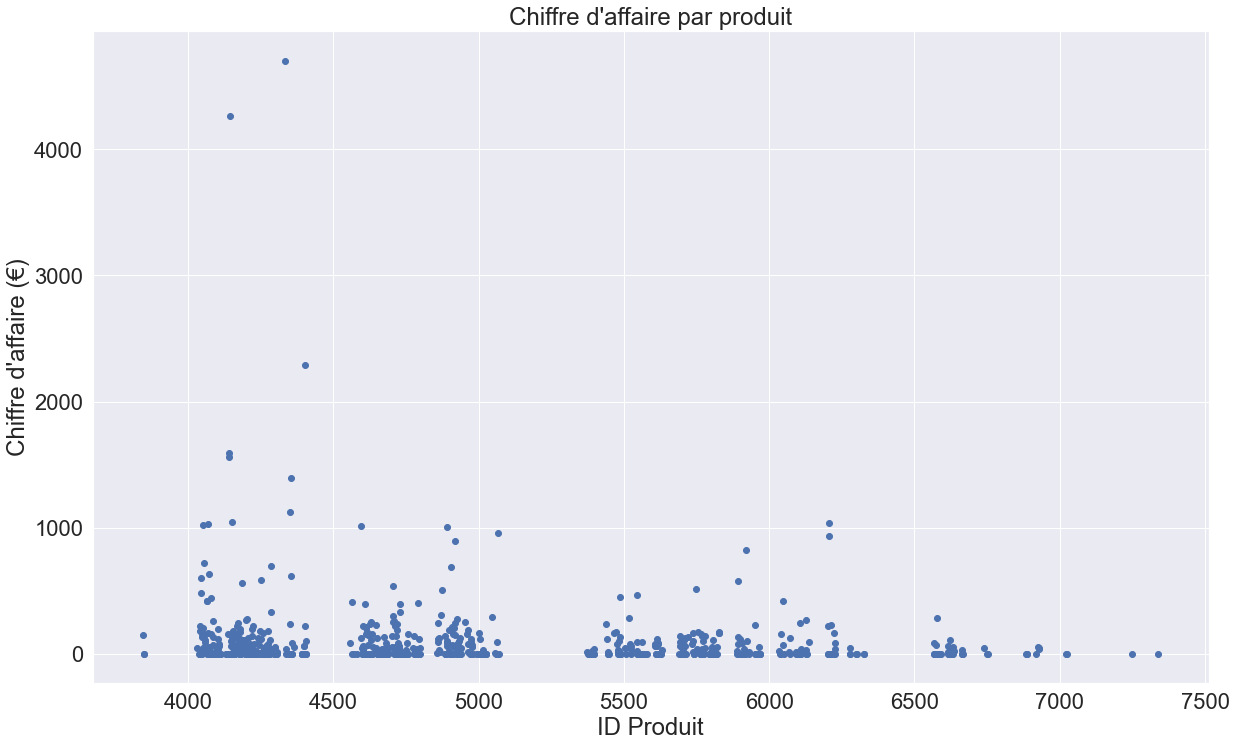

In [41]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
plt.plot(data["product_id"], data["ca_par_produit"],'o')
plt.xlabel("ID Produit")
plt.ylabel("Chiffre d'affaire (€)")
plt.title("Chiffre d'affaire par produit")
plt.show()

## 2) Chiffre d'affaire total <a class="anchor" id="ii2"></a>

In [42]:
print('\033[1m' "Le total du chiffre d'affaire réalisé en ligne est de " '\033[4m' + str(data.ca_par_produit.sum()) + "€" '\033[0m')

Le total du chiffre d'affaire réalisé en ligne est de 70568.6€


# III) Recherche d'outliers <a class="anchor" id="iii"></a>

In [43]:
data.describe()

,product_id,onsale_web,price,stock_quantity,total_sales,post_author,ca_par_produit
count,825.000000,825.000000,825.000000,825.000000,714.000000,714.000000,714.000000
mean,5162.597576,0.869091,32.415636,26.496970,4.012605,1.998599,98.835574
std,902.644635,0.337506,26.795849,45.892422,8.518183,0.037424,307.685071
min,3847.000000,0.000000,5.200000,0.000000,0.000000,1.000000,0.000000
25%,4348.000000,1.000000,14.600000,1.000000,0.000000,2.000000,0.000000
50%,4907.000000,1.000000,24.400000,11.000000,1.000000,2.000000,15.250000
75%,5805.000000,1.000000,42.000000,34.000000,4.000000,2.000000,91.150000
max,7338.000000,1.000000,225.000000,578.000000,96.000000,2.000000,4704.000000


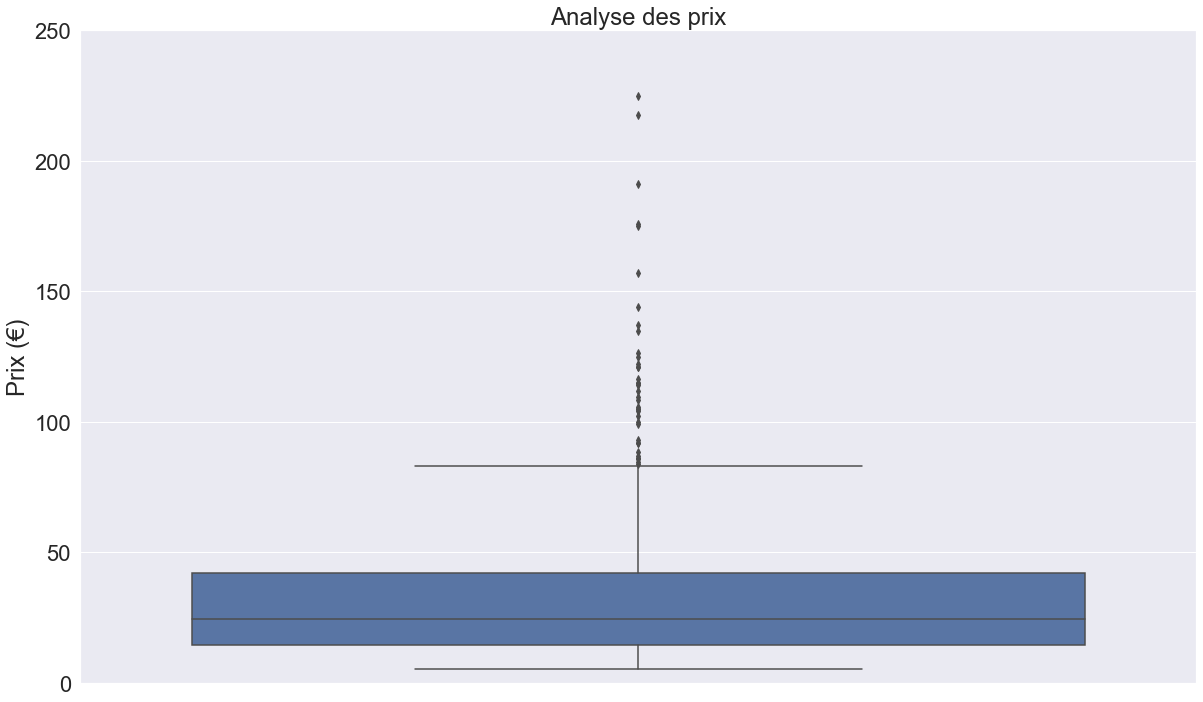

In [44]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
sns.boxplot(data=data, y=data['price'])
plt.title("Analyse des prix")
plt.ylabel("Prix (€)")
plt.ylim(0, 250)
plt.show()

Pour déterminer les outliers, nous utilisons l'écart interquartile IQ (soit Q3 - Q1). Dans un boxplot, les moustaches ne dépassent pas 1.5 * IQ. Dans notre cas, IQ = 42 - 14.6 = 26.4.

1.5 * IQ vaut donc 39.6.

En additionnant IQ à Q3, on obtient la valeur limite de notre moustache, à savoir 81.6. Toutes les valeurs au delà peuvent être considérées comme des outliers.

In [45]:
data.loc[data['price'] > 81.6, :].sort_values('price', ascending=False).reset_index()

,index,sku,product_id,onsale_web,price,stock_quantity,stock_status,total_sales,post_author,post_date,post_title,ca_par_produit
0,291,15940,4352,1,225.0,0,outofstock,5.0,2.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,1125.0
1,525,14581,5001,1,217.5,20,instock,0.0,2.0,2018-07-17 09:45:39,David Duband Charmes-Chambertin Grand Cru 2014,0.0
2,692,14983,5892,1,191.3,10,instock,3.0,2.0,2019-03-28 10:21:36,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,573.9
3,310,3510,4402,1,176.0,8,instock,13.0,2.0,2018-03-22 11:21:05,Cognac Frapin VIP XO,2288.0
4,657,15185,5767,1,175.0,12,instock,0.0,2.0,2019-03-13 14:43:22,Camille Giroud Clos de Vougeot 2016,0.0
5,313,7819,4406,1,157.0,3,instock,0.0,2.0,2018-03-22 11:42:48,Cognac Frapin Château de Fontpinot 1989 20 Ans...,0.0
6,30,NaN,4594,1,144.0,0,outofstock,NaN,NaN,NaT,NaN,NaN
7,478,14220,4904,1,137.0,13,instock,5.0,2.0,2018-05-15 10:23:41,Domaine Des Croix Corton Charlemagne Grand Cru...,685.0
8,752,14923,6126,1,135.0,10,instock,2.0,2.0,2019-06-28 17:22:27,Champagne Gosset Célébris Vintage 2007,270.0
9,293,12589,4355,1,126.5,2,instock,11.0,2.0,2018-03-02 10:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,1391.5


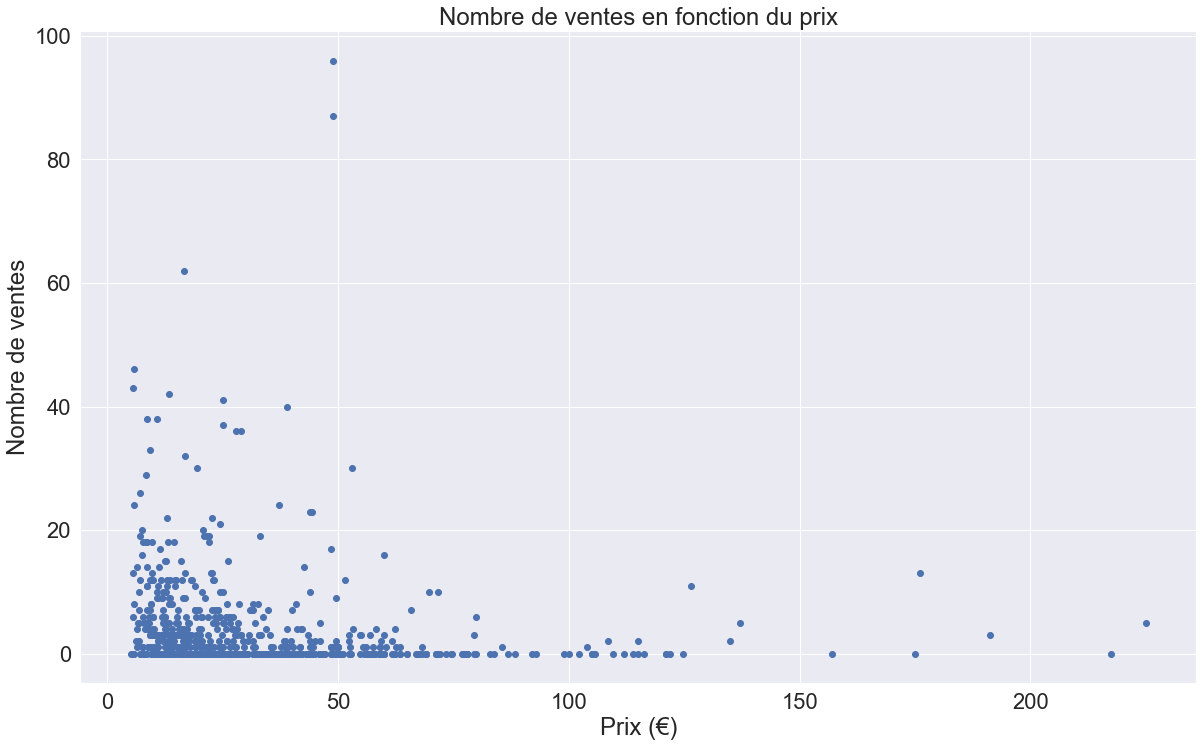

In [46]:
#Les valeurs au dela de la moustache sont des outliers, mais sont-elles des valeurs aberrantes ?
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
plt.plot(data["price"],data["total_sales"],'o')
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de ventes")
plt.title("Nombre de ventes en fonction du prix")
plt.show()

# Conclusion <a class="anchor" id="conclusion"></a>

Sans informations supplémentaires, nous n'avons pas pu déterminer les SKU manquants.

Malgré la présence d'outliers, il ne semble pas y avoir de valeurs aberrantes parmi les prix des produits.